In [72]:
# Imports
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np

from matplotlib import pyplot as plt

import time

import pandas as pd

import urllib.request

In [73]:
# Model parameters
MASTER_CONFIG = {
    "vocab_size": 65,       # Number of unique characters in the dataset
    "batch_size": 32,       # Number of batches
    "context_window": 16,   # Number of characters in a batch
    "d_model": 128,         # Dimension of linear layers
    "epochs": 1000,         # Number of training epochs
    "log_interval": 10      # Frequency of logging the loss in epochs
}

# Data Preprocessing

In [74]:
# Tiny Shakespeare
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
file_name = "tinyshakespeare.txt"
urllib.request.urlretrieve(url, file_name)

('tinyshakespeare.txt', <http.client.HTTPMessage at 0x7b458124ee30>)

In [75]:
# Create vocab list of unique chars
lines = open("tinyshakespeare.txt", 'r').read()
vocab = sorted(list(set(lines)))

print("First 10 chars of vocab list:", vocab[:10])
print("Vocab size:", len(vocab))

First 10 chars of vocab list: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3']
Vocab size: 65


In [76]:
# Int to string
itos = {i: ch for i, ch in enumerate(vocab)}

# String to int
stoi = {ch: i for i, ch in enumerate(vocab)}

In [77]:
# Encoding and decoding
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

# Example
print(encode("hello world"))
print(decode(encode("hello world")))

[46, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42]
hello world


In [78]:
# Convert dataset into a tensor
dataset = torch.tensor(encode(lines), dtype=torch.int8)

# Approximately 1 million tokens (chars)
print(dataset.shape)

torch.Size([1115394])


In [79]:
# Split dataset into train/val/test batches
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
  # Train/val/test split = 0.8/0.1/0.1
  train = data[:int(0.8 * len(data))]
  val = data[int(0.8 * len(data)):int(0.9 * len(data))]
  test = data[int(0.9 * len(data)):]

  # Determine which batch to use
  batch_data = train
  if split == "val":
    batch_data = val
  elif split == "test":
    batch_data = test

  # batch_size number of random starting points in the data
  ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))

  # Input and target sequences
  x = torch.stack([batch_data[i:i + context_window] for i in ix]).long()
  y = torch.stack([batch_data[i + 1:i + context_window + 1] for i in ix]).long()

  return x, y

In [80]:
# Obtain batches for training
xs, ys = get_batches(dataset, "train", MASTER_CONFIG["batch_size"], MASTER_CONFIG["context_window"])

# Decode batches
decoded_samples = [(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

# (sample, target)
print(decoded_samples)

[('ut far unfit to ', 't far unfit to b'), ('nt\nTo spend the ', 't\nTo spend the t'), ('nocent milk in i', 'ocent milk in it'), ("I can't say your", " can't say your "), ('!\n\nAUFIDIUS:\nWhy', '\n\nAUFIDIUS:\nWhy,'), ('eks.\n\nKING EDWAR', 'ks.\n\nKING EDWARD'), ('aw good strawber', 'w good strawberr'), ('ow, good sir,\nYo', 'w, good sir,\nYou'), ('es of our blood\n', 's of our blood\nW'), (' as hot a Jack i', 'as hot a Jack in'), ('eapons to the gr', 'apons to the gro'), ('teach me how to ', 'each me how to f'), ('rsons whose name', 'sons whose names'), ('e swears,\nAs he ', ' swears,\nAs he h'), ('ff,\nConceiving y', 'f,\nConceiving yo'), (';\nFor by his fac', '\nFor by his face'), (' to:\nA man at le', 'to:\nA man at lea'), ('ty may dissolve ', 'y may dissolve t'), ('young and noble ', 'oung and noble g'), ('he master: if an', 'e master: if any'), ('an he will stand', 'n he will stand\n'), ('ollow:\nThe Volsc', 'llow:\nThe Volsce'), ('duit, girl? what', 'uit, girl? what,'), ('Than

# Loss

In [81]:
# Computes the mean loss for 10 batches for train/val
@torch.no_grad()
def evaluate_loss(model, config=MASTER_CONFIG):
  out = {}

  # Set the model to evaluation mode
  model.eval()

  # Iterate through train and val splits
  for split in ["train", "val"]:
    losses = []

    # Get 10 sample batches
    for _ in range(10):
      # Input and target sequences
      xb, yb = get_batches(dataset, split, config["batch_size"], config["context_window"])
      # Run the model and calculate the loss
      _, loss = model(xb, yb)
      losses.append(loss.item())

    out[split] = np.mean(losses)

  # Set the model to train mode
  model.train()

  return out

# Base Model

In [82]:
class BaseNN(nn.Module):
  def __init__(self, config=MASTER_CONFIG):
    super().__init__()
    self.config = config

    # Embedding layer to convert character indices to vectors
    self.embedding = nn.Embedding(config["vocab_size"], config["d_model"])
    # Linear layers
    self.linear = nn.Sequential(
        nn.Linear(config["d_model"], config["d_model"]),
        nn.ReLU(),
        nn.Linear(config["d_model"], config["vocab_size"])
    )

    print("# of params:", sum(p.numel() for p in self.parameters()))

  def forward(self, idx, targets=None):
    # Embedding layer converts character indices to vectors
    x = self.embedding(idx)
    # Linear layers
    logits = self.linear(x)

    # If there are targets, calculate and return the cross entropy loss
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1, self.config["vocab_size"]), targets.view(-1))
      return logits, loss

    return logits

In [83]:
# Initialize model
model = BaseNN(MASTER_CONFIG)

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters())

# of params: 33217


In [84]:
# Calculate sample logits and loss
xs, ys = get_batches(dataset, "train", MASTER_CONFIG["batch_size"], MASTER_CONFIG["context_window"])
logits, loss = model(xs, ys)

print("Logits shape:", logits.shape)
print("Loss:", loss.item())

Logits shape: torch.Size([32, 16, 65])
Loss: 4.1323065757751465


In [85]:
# Training loop
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
  losses = []
  start_time = time.time()

  # Iterate through epochs
  for epoch in range(config["epochs"]):
    # Zero out gradients
    optimizer.zero_grad()

    # Get training batches
    xs, ys = get_batches(dataset, "train", config["batch_size"], config["context_window"])
    # Run the model and calculate the loss
    logits, loss = model(xs, targets=ys)
    # Backpropagate the loss
    loss.backward()
    # Step the optimizer
    optimizer.step()

    # If there's a learning rate scheduler, adjust the learning rate
    if scheduler:
      scheduler.step()

    # Log progress
    if epoch % config["log_interval"] == 0:
      # Calculate batch time
      batch_time = time.time() - start_time

      # Evaluate loss
      x = evaluate_loss(model)
      losses += [x]

      # Print progress
      if print_logs:
        print(f"Epoch: {epoch} | Train loss: {x['train']:0.3f} | Val loss: {x['val']:0.3f} | Time: {batch_time:0.3f} | ETA (sec): {batch_time * (config['epochs'] - epoch) / config['log_interval']:0.3f}")

      # Reset timer
      start_time = time.time()

      # Print learning rate
      if scheduler:
        print("Learning rate:", scheduler.get_last_lr())

  print("Val loss:", losses[-1]["val"])

  return pd.DataFrame(losses).plot()

# of params: 33217
Epoch: 0 | Train loss: 4.106 | Val loss: 4.099 | Time: 0.013 | ETA (sec): 1.285
Epoch: 10 | Train loss: 3.550 | Val loss: 3.567 | Time: 0.071 | ETA (sec): 7.045
Epoch: 20 | Train loss: 3.194 | Val loss: 3.194 | Time: 0.051 | ETA (sec): 5.042
Epoch: 30 | Train loss: 2.948 | Val loss: 2.999 | Time: 0.050 | ETA (sec): 4.831
Epoch: 40 | Train loss: 2.799 | Val loss: 2.810 | Time: 0.056 | ETA (sec): 5.338
Epoch: 50 | Train loss: 2.711 | Val loss: 2.785 | Time: 0.050 | ETA (sec): 4.711
Epoch: 60 | Train loss: 2.744 | Val loss: 2.734 | Time: 0.051 | ETA (sec): 4.823
Epoch: 70 | Train loss: 2.647 | Val loss: 2.682 | Time: 0.051 | ETA (sec): 4.764
Epoch: 80 | Train loss: 2.657 | Val loss: 2.701 | Time: 0.064 | ETA (sec): 5.866
Epoch: 90 | Train loss: 2.659 | Val loss: 2.636 | Time: 0.050 | ETA (sec): 4.548
Epoch: 100 | Train loss: 2.621 | Val loss: 2.676 | Time: 0.050 | ETA (sec): 4.539
Epoch: 110 | Train loss: 2.585 | Val loss: 2.657 | Time: 0.056 | ETA (sec): 4.964
Epoch: 1

<Axes: >

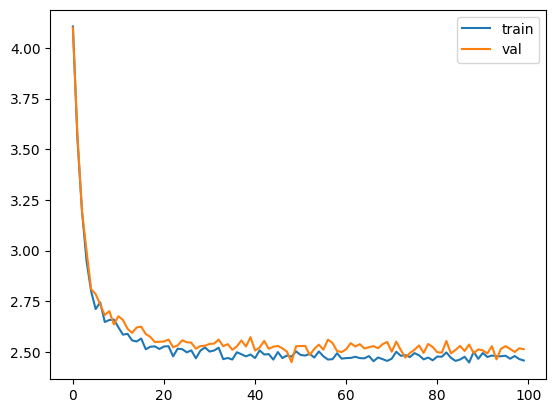

In [86]:
# Reinit model and optimizer
model = BaseNN(MASTER_CONFIG)
optimizer = torch.optim.Adam(model.parameters())

# Train model
train(model, optimizer, print_logs=True)

# Generating Text

In [87]:
# Generate text using the model
def generate(model, config=MASTER_CONFIG, num_texts=5, max_new_tokens=30):
  # Initialize with zeros = '\n'
  idx = torch.zeros(num_texts, 1).long()

  for _ in range(max_new_tokens):
    # Call the model
    logits = model(idx[:, -config["context_window"]:])
    # Get the newest logits: [all batches, last time step, all logits]
    last_time_step_logits = logits[:, -1, :]
    # Softmax probabilities
    p = F.softmax(last_time_step_logits, dim=-1)
    # Get the next token from the probabilities
    idx_next = torch.multinomial(p, num_samples=1)
    # Append the token
    idx = torch.cat([idx, idx_next], dim=-1)

  # Return the decoded tokens
  return [decode(x) for x in idx.tolist()]

In [88]:
generate(model)

['\nbr y me th: cud t alarow ndeth',
 '\nooou.\nWh.\nI d h ffed\n\nI impour',
 '\nICisscke, m, rn knded owizerem',
 "\nWhen d.\nS:\n\nQ'ly palu.\nSe blin",
 '\nIOUCayegnth gouthou rel he ppe']